## UMAP visualization

### Import packages and setup enviornment

In [1]:
from umap import UMAP
import umap.plot
import matplotlib.pyplot as plt
import time
import datetime
import seaborn as sns
import sklearn.datasets as skn

import pandas as pd
import numpy as np

### Read cleaned data

In [38]:
df_final = pd.read_csv('df_final.csv', index_col = 0)
genre_10 = pd.read_csv('genre_10.csv', index_col = 0)

In [39]:
df_final['track_genre_val'].value_counts()

rock                      30173
indie                     17721
pop                       13490
electronic                11921
Hip-Hop                    7618
                          ...  
forever begins tonight        1
nicole mullen                 1
mmm the mint chicks           1
heavy rock                    1
getthis                       1
Name: track_genre_val, Length: 5769, dtype: int64

In our visualization, we would like to use track genre as our target label, but the genre space is very sparse, with 5769 unique track genres. Plotting a map of 5k labels would obsucre our analysis, especially when some track genre appeared only once. Hence, we decided to only label the top 13 track genres and label all other track genre as "other" and "None" genre as "NA", resulting in 15 labels for visualization at the end.

### Read top 13 genre tags for further data cleaning

In [40]:
genre_10 = list(genre_10['genre'])

In [41]:
def get_genre(genre):
    if genre in genre_10:
        return genre
    if genre != genre:
        return 'NA'
    return 'other'

In [42]:
df_final['track_genre'] = df_final['track_genre_val'].apply(lambda x: get_genre(x))

In [43]:
df_final = df_final.drop('track_genre_val', axis = 1)

In [44]:
df_final['track_genre'].value_counts()

NA                  211369
other               193959
rock                 30173
indie                17721
pop                  13490
alternative           6945
alternative rock      3093
Love                   637
favorites              415
Mellow                 378
00s                    364
beautiful              348
Awesome                268
male vocalists         171
american               167
Name: track_genre, dtype: int64

The above list counts the occurrence of each of the 15 track genre labels. Note that due to the sparse genre space, NA and other genre takes up the largest proportions of the space.

In [46]:
# for umap learning, we would like to integer encode the categorical variables: artist term and track genre
df_final['artist_term'] = df_final['artist_term'].astype('category')
df_final['artist_term'] = df_final['artist_term'].cat.codes

df_final['year'] = df_final['year'].astype('category')

In [47]:
df_final

,duration,artist_familiarity,artist_hotttnesss,count,artist_term,year,track_genre
3,265.16853,0.649822,0.394032,1,90,1989.0,rock
14,405.23710,0.649822,0.394032,2,90,1989.0,other
15,380.81261,0.649822,0.394032,1,90,1989.0,other
18,327.02649,0.649822,0.394032,4,90,1987.0,other
19,275.06893,0.649822,0.394032,1,90,1989.0,other
...,...,...,...,...,...,...,...
599988,348.10730,0.478736,0.361698,1,0,1990.0,NA
599989,348.10730,0.478736,0.361698,10,0,1990.0,NA
599990,348.10730,0.478736,0.361698,1,0,1990.0,NA
599991,348.10730,0.478736,0.361698,2,0,1990.0,NA


Out of concern that the sheer size of the other and the NA genres would obscure the visualization, we also prepared a dataset that excludes other and NA genre for a back-up visualization.

In [48]:
df_plot = df_final[df_final['track_genre'] != 'other']

In [49]:
df_plot = df_plot[df_plot['track_genre'] != 'NA']

In [50]:
df_plot

,duration,artist_familiarity,artist_hotttnesss,count,artist_term,year,track_genre
3,265.16853,0.649822,0.394032,1,90,1989.0,rock
75,176.14322,0.588156,0.401092,1,90,1992.0,indie
76,193.54077,0.625929,0.401092,4,90,1992.0,indie
77,193.54077,0.625929,0.401092,14,90,1992.0,indie
82,193.54077,0.625929,0.401092,6,90,1992.0,indie
...,...,...,...,...,...,...,...
334068,311.27465,0.865022,0.916053,1,90,2002.0,pop
334069,311.27465,0.865022,0.916053,1,90,2002.0,pop
334071,311.27465,0.865022,0.916053,2,90,2002.0,rock
334087,311.27465,0.865022,0.916053,1,90,2002.0,rock


### Data preparation for UMAP parameter tunings

In [57]:
data_withNAother = df_final.sample(20000)[
    [
        "duration",
        "artist_familiarity",
        "artist_hotttnesss",
        "count",
        "artist_term",
        "year"
    ]
].values

In [52]:
data_withoutNAother = df_plot[
    [
        "duration",
        "artist_familiarity",
        "artist_hotttnesss",
        "count",
        "artist_term",
        "year"
    ]
].values

In [58]:
from sklearn.preprocessing import StandardScaler
scaled_data_withNAother = StandardScaler().fit_transform(data_withNAother)
scaled_data_withNAother = StandardScaler().fit_transform(data_withoutNAother)

### Parameter tuning for UMAP on datasets with/ without NA and other genre

#### Summary: work flow of this section
1. parameter tuning using 70k+ data (with other and NA genre, full dataset): 

    #### tuned on spread, n_neighbor, min_dist, n_epoch

    i. logic resembles that of the basic recommendation: control the rest and change one to get a range of best looking parameters
    
    ii. grid search on 3*3 grid of parameters and find the best looking set of parameters

2. parameter tuning using random sampled 20k data (without other and NA) for fast tuning

    #### tuned on spread, n_neighbor, min_dist, n_epoch
    
    the same workflow as in bullet 1, for dataset with other and NA genre
    
    
3. plot full dataset with NA and other (200k) & without NA and other (70k)

In [22]:
# Parameters for fine tuning
spread = [0.1, 0.5, 0.75, 1, 1.5, 2, 3, 5, 10] # default = 1
n_neighbors = [2, 5, 10, 20, 50, 100, 200, 500, 1000] # default = 15
min_dist = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 1.5, 2] # default = 0.1
n_epoch = [] # default = None; 200 for large dataset, 500 for small

1. Dataset with NA and other genre

In [21]:
np.random.seed = 66

In [26]:
mapper_withNAother = UMAP(random_state=66, n_components=2, verbose = True, 
              spread = 2, n_neighbors = 200,
             min_dist = 0.001).fit(scaled_data_withNAother)

UMAP(dens_frac=0.0, dens_lambda=0.0, min_dist=0.001, n_neighbors=200,
     random_state=66, spread=2, verbose=True)
Construct fuzzy simplicial set
Sun May 16 00:12:13 2021 Finding Nearest Neighbors
Sun May 16 00:12:13 2021 Building RP forest with 19 trees
Sun May 16 00:12:13 2021 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
Sun May 16 00:17:38 2021 Finished Nearest Neighbor Search
Sun May 16 00:17:41 2021 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun May 16 00:20:40 2021 Finished embedding


<AxesSubplot:>

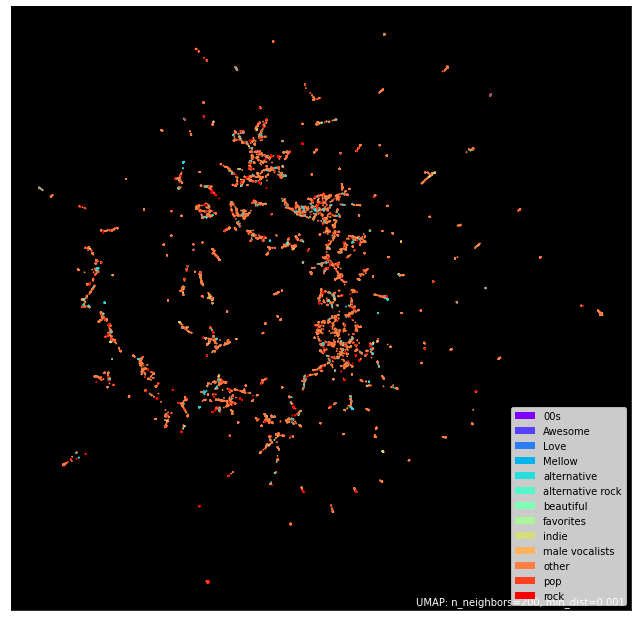

In [25]:
labels = df_final['track_genre'][:20000]
umap.plot.points(mapper_withNAother, labels = labels, theme = 'fire')
# plt.savefig('10_0.01_100_percent_400k_66.eps')

2. Dataset without NA and other genre

In [ ]:
mapper_withoutNAother = UMAP(random_state=66, n_components=2, verbose = True, 
              spread = 2, n_neighbors = 200,
             min_dist = 0.001).fit(scaled_data_withoutNAother)

<AxesSubplot:>

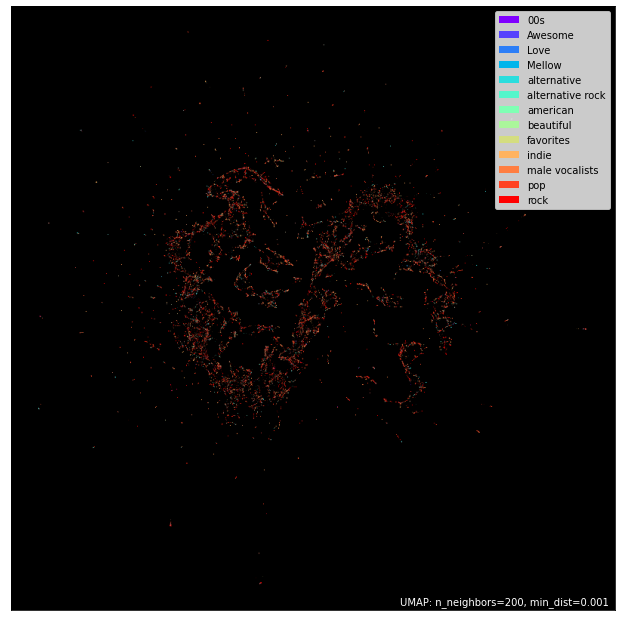

In [30]:
labels = df_plot['track_genre']
umap.plot.points(mapper_withoutNAother, labels = labels, theme = 'fire')
# plt.savefig('10_0.01_100_percent_400k_66.eps')

### Final selected UMAP learning and plot with selected dataset and selected parameters

In [12]:
start_time = time.time()

In [26]:
mapper = UMAP(random_state=66, n_components=2, verbose = True, 
              spread = 2, n_neighbors = 200,
             min_dist = 0.001).fit(scaled_data_withNAother)

UMAP(dens_frac=0.0, dens_lambda=0.0, min_dist=0.001, n_neighbors=200,
     random_state=66, spread=2, verbose=True)
Construct fuzzy simplicial set
Sun May 16 00:12:13 2021 Finding Nearest Neighbors
Sun May 16 00:12:13 2021 Building RP forest with 19 trees
Sun May 16 00:12:13 2021 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
Sun May 16 00:17:38 2021 Finished Nearest Neighbor Search
Sun May 16 00:17:41 2021 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun May 16 00:20:40 2021 Finished embedding


<AxesSubplot:>

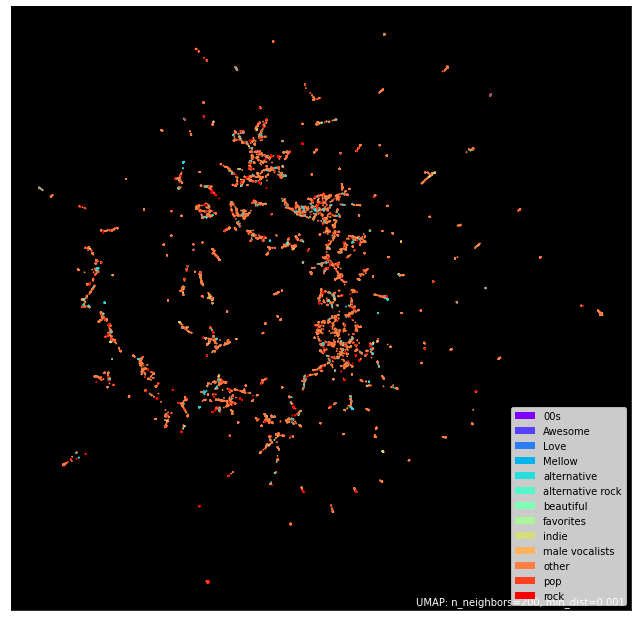

In [25]:
labels = df_final['track_genre'][:20000]
umap.plot.points(mapper, labels = labels, theme = 'fire')
# plt.savefig('10_0.01_100_percent_400k_66.eps')

In [ ]:
end_time = time.time()

In [ ]:
str(datetime.timedelta(seconds = end_time - start_time))